<a href="https://colab.research.google.com/github/joyccino/cifar10withCNN/blob/main/cifar10withCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import modules
import tensorflow as tf
from tensorflow.keras.datasets import cifar10 #Tensorflow Keras backend
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical #One hot encoding
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import numpy as np
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data load + preprocessing
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

print(x_train_full.shape, y_train_full.shape)
print(x_test.shape, y_test.shape) 

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


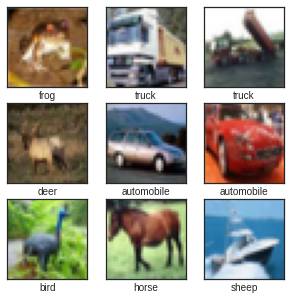

In [3]:
np.random.seed(777)

# Data check
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog','frog','horse','sheep','truck']

sample_size = 9
random_idx = np.random.randint(60000, size=sample_size)

plt.figure(figsize = (5,5))
for i, idx in enumerate(random_idx):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train_full[i])
  plt.xlabel(class_names[int(y_train_full[i])])

plt.show()

In [4]:
# 모델 제작 위한 전처리 작업
x_mean = np.mean(x_train_full, axis=(0, 1, 2))
x_std = np.std(x_train_full, axis=(0, 1, 2))

x_train_full = (x_train_full - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3)

In [6]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(35000, 32, 32, 3)
(35000, 1)
(15000, 32, 32, 3)
(15000, 1)
(10000, 32, 32, 3)
(10000, 1)


# Data summary
* According to its shape, 총 32X32X3 = 3,072 개의 가중치(weight)가 필요하다.

# CNN 의 레이어 구성:
1) input layer : 인풋 이미지가 들어오는 레이어 <br>
2) conv layer : 인풋 이미지의 일부 수용영역 (receptive field) 에 대하여 conv 연산을 수행 <br>
3) ReLU layer : 일반적으로 사용되는 액티베이션 함수 <br>
4) Pool layer : width x height 에 대해 downsampling 수행 <br>
5) FC layer <br>

In [7]:
# Compose model and compile
def model_build():
  model = Sequential()

  input = Input(shape=(32, 32, 3)) #cifar10 텐서 (height, width, 채널)

  output = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Flatten()(output) #3차원 to 1차원
  output = Dense(256, activation='relu')(output) #은닉층 개념
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output) #출력층

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [8]:
model = model_build()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0     

In [9]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1) 
# (Epochs:Val_acc) 43:0.68, 45:0.6943, 39:0.6911
                  
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=(early_stopping)) 
model.save('/content/drive/MyDrive/cifar10wCNN/model1')

Epoch 1/100
137/137 [==============================] - 34s 17ms/step - loss: 1.8737 - accuracy: 0.3398 - val_loss: 1.6202 - val_accuracy: 0.4251
Epoch 2/100
137/137 [==============================] - 2s 14ms/step - loss: 1.5178 - accuracy: 0.4627 - val_loss: 1.4343 - val_accuracy: 0.4910
Epoch 3/100
137/137 [==============================] - 2s 13ms/step - loss: 1.3875 - accuracy: 0.5087 - val_loss: 1.3629 - val_accuracy: 0.5155
Epoch 4/100
137/137 [==============================] - 2s 13ms/step - loss: 1.3117 - accuracy: 0.5375 - val_loss: 1.2995 - val_accuracy: 0.5352
Epoch 5/100
137/137 [==============================] - 2s 14ms/step - loss: 1.2577 - accuracy: 0.5578 - val_loss: 1.2571 - val_accuracy: 0.5549
Epoch 6/100
137/137 [==============================] - 2s 13ms/step - loss: 1.2058 - accuracy: 0.5795 - val_loss: 1.2088 - val_accuracy: 0.5703
Epoch 7/100
137/137 [==============================] - 2s 14ms/step - loss: 1.1604 - accuracy: 0.5947 - val_loss: 1.1782 - val_accuracy

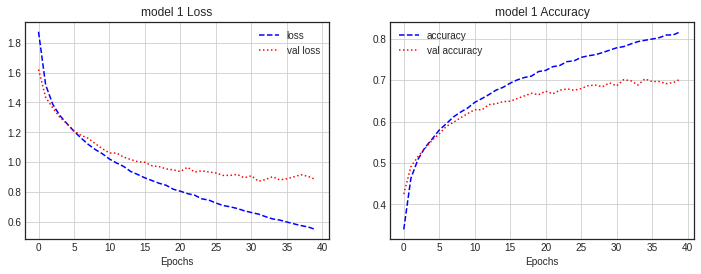

In [18]:
# 학습 과정 시각화

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r:', label='val loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 1 Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r:', label='val accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 1 Accuracy')
plt.savefig('/content/drive/MyDrive/cifar10wCNN/model1')
plt.show()

# Model1 Feedback:
* 문제: Model1 에서 overfitting 일어나고 있는 것 확인
* 원인: 파라미터가 음 -> 모델의 복잡도가 높음
* 대안 : 모델을 간소하게 정규화(regularisation) 하는 방법 중 dropout 기법과 Batch normalisation을 번갈아가며 적용해볼 것임.
* Dropout Reference: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

# Dropout
* 원리 : 기존의 Regularisation 기법 (L1 Lasso or L2 Ridge)들은 열심히 일하지 않는 node 를 죽이는 기능. <br>
하지만 L1, L2 로는 찾을 수 없는 node 가 있는데, 열심히 일하는것처럼 보이지만 단 2개의 node 끼리만 협력하고 실제 Loss 에는 영향을 미치지 않는 경우가 있음. 이런 현상을 co-adaptation 이라고 하는데, 이것을 해결하기 위한 방법이 dropout 임.

* Dropout 특징: Dropout 을 통해 무작위로 nodes 를 삭제하게 되는데, 삭제 확률은 hyperparameter (generally 0.5)로 지정해주어야 함. <br>
Dropout 은 1 epoch 마다 진행되기 때문에, 1 epoch 마다 학습되는 노드가 다름.
* dropout 을 ensemble 기법이라 표현하기도 하는 이유: 서로 다른 N개의 신경망을 매 epoch 마다 학습하게 되는 것 -> 최종적으로는 weighted sum으로 concat 됨

In [11]:
# Compose model and compile (Dropout only)
def model_build2():

  #Define the convolution net
  model2 = Sequential()

  input = Input(shape=(32, 32, 3))
  # CONV => RELU => CONV => RELU => POOL => DROPOUT
  output = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)

  output = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)


  output = Flatten()(output)
  output = Dense(256, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model2 = Model(inputs=[input], outputs=output)

  model2.compile(optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model2

In [12]:
model2 = model_build2()
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         7385

In [13]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)

history2 = model2.fit(x_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping]) 
model2.save('/content/drive/MyDrive/cifar10wCNN/model2')

Epoch 1/100
137/137 [==============================] - 3s 16ms/step - loss: 2.2418 - accuracy: 0.1574 - val_loss: 2.0831 - val_accuracy: 0.2641
Epoch 2/100
137/137 [==============================] - 2s 14ms/step - loss: 2.0263 - accuracy: 0.2526 - val_loss: 1.9061 - val_accuracy: 0.3274
Epoch 3/100
137/137 [==============================] - 2s 14ms/step - loss: 1.8640 - accuracy: 0.3117 - val_loss: 1.7261 - val_accuracy: 0.3747
Epoch 4/100
137/137 [==============================] - 2s 14ms/step - loss: 1.7211 - accuracy: 0.3614 - val_loss: 1.5919 - val_accuracy: 0.4281
Epoch 5/100
137/137 [==============================] - 2s 13ms/step - loss: 1.6365 - accuracy: 0.3934 - val_loss: 1.5263 - val_accuracy: 0.4524
Epoch 6/100
137/137 [==============================] - 2s 14ms/step - loss: 1.5775 - accuracy: 0.4211 - val_loss: 1.4780 - val_accuracy: 0.4683
Epoch 7/100
137/137 [==============================] - 2s 14ms/step - loss: 1.5328 - accuracy: 0.4344 - val_loss: 1.4248 - val_accuracy:

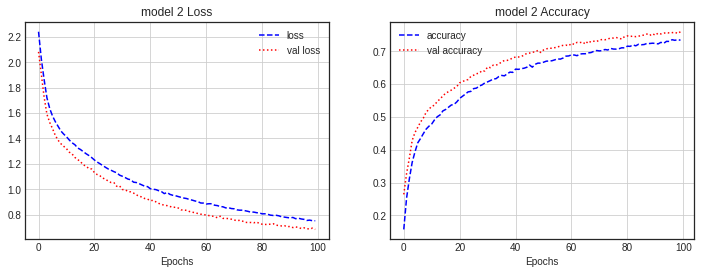

In [19]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], 'b--', label='loss')
plt.plot(history2.history['val_loss'], 'r:', label='val loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 2 Loss')

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], 'b--', label='accuracy')
plt.plot(history2.history['val_accuracy'], 'r:', label='val accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 2 Accuracy')
plt.savefig('/content/drive/MyDrive/cifar10wCNN/model2')
plt.show()

# Model2 Feedback:
과적합 문제가 많이 개선된 것 알 수 있음. <br>
런타임 초기화 후 학습을 몇번 반복한 결과 평균적으로 epoch=100, val_accuracy=0.76 정도의 성능 보임. <br>
Batch Normalisation 을 함께 사용하면 더 나은 성능을 보일까?

In [20]:
# Compose model and compile (Dropout + Batch Normalisation)
def model_build3():
  model3 = Sequential()

  input = Input(shape=(32, 32, 3))

  output = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)

  output = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)


  output = Flatten()(output)
  output = Dense(256, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model3 = Model(inputs=[input], outputs=output)

  model3.compile(optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model3

In [21]:
model3 = model_build3()
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0   

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1) 

history3 = model3.fit(x_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping]) 
model3.save('/content/drive/MyDrive/cifar10wCNN/model3')

Epoch 1/100
137/137 [==============================] - 3s 18ms/step - loss: 2.7253 - accuracy: 0.1598 - val_loss: 2.2662 - val_accuracy: 0.2253
Epoch 2/100
137/137 [==============================] - 2s 16ms/step - loss: 2.1202 - accuracy: 0.2295 - val_loss: 2.2091 - val_accuracy: 0.2705
Epoch 3/100
137/137 [==============================] - 2s 16ms/step - loss: 1.9881 - accuracy: 0.2688 - val_loss: 1.9323 - val_accuracy: 0.3301
Epoch 4/100
137/137 [==============================] - 2s 16ms/step - loss: 1.8923 - accuracy: 0.3004 - val_loss: 1.7310 - val_accuracy: 0.3825
Epoch 5/100
137/137 [==============================] - 2s 16ms/step - loss: 1.8171 - accuracy: 0.3246 - val_loss: 1.6335 - val_accuracy: 0.4065
Epoch 6/100
137/137 [==============================] - 2s 16ms/step - loss: 1.7609 - accuracy: 0.3441 - val_loss: 1.5775 - val_accuracy: 0.4257
Epoch 7/100
137/137 [==============================] - 2s 16ms/step - loss: 1.7056 - accuracy: 0.3671 - val_loss: 1.5412 - val_accuracy:

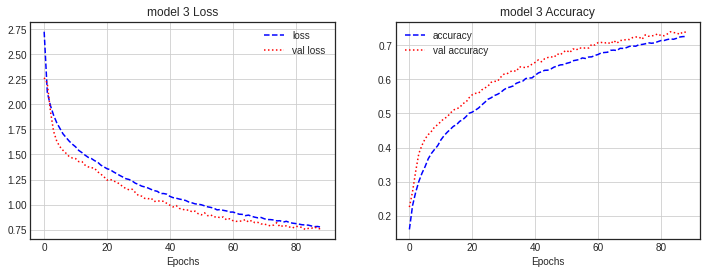

In [23]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], 'b--', label='loss')
plt.plot(history3.history['val_loss'], 'r:', label='val loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 3 Loss')

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], 'b--', label='accuracy')
plt.plot(history3.history['val_accuracy'], 'r:', label='val accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 3 Accuracy')
plt.savefig('/content/drive/MyDrive/cifar10wCNN/model3')
plt.show()

# Model3 Feedback:
평균 epoch= 100 에서 val_accuracy = 0.740, Loss = 0.742 을 기록하였음. <br>
앞선 모델 1, 2와 비교해 both accuracies 및 losses 가 거의 비슷하게 측정 됨. <br>
trainset 과 validationset 에 대한 loss 와 accuracy 트렌드 유사 = overfitting or underfitting 되었을 확률 낮음. <br>

# Increase Validation Accuracy
Overfitting 방지 + Loss 떨어트리는 노력 했으니 accuracy 향상 할 차례. <br>
ML model 은 데이터의 양이 많을 수록 더 높은 성능을 보이는 경향이 있기 때문에<br>
ImageDataGenerator 사용하여 다양한 변화 (Image Augmentation) 주면서 원본 데이터 증강 시켜주는 과정 적용해보자.

In [24]:
gen = ImageDataGenerator(rotation_range=20,
                         shear_range=0.2,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         horizontal_flip=True)

augment_ratio = 1.5 # 전체 데이터의 150%
augment_size = int(augment_ratio * x_train.shape[0])

randidx = np.random.randint(x_train.shape[0], size=augment_size)

x_augmented = x_train[randidx].copy() 
y_augmented = y_train[randidx].copy()

x_augmented, y_augmented = gen.flow(x_augmented, y_augmented, #gen.flow() :  보강할 이미지 데이터 생성 매서드
                                    batch_size=augment_size,
                                    shuffle=False).next()

x_train = np.concatenate( (x_train, x_augmented) )
y_train = np.concatenate( (y_train, y_augmented) )

s = np.arange(x_train.shape[0])
np.random.shuffle(s)

x_train = x_train[s]
y_train = y_train[s]

In [25]:
# Compose model and compile (Dropout + Batch Normalisation)
def model_build4():
  model4 = Sequential()

  input = Input(shape=(32, 32, 3))

  output = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)

  output = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)


  output = Flatten()(output)
  output = Dense(256, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model4 = Model(inputs=[input], outputs=output)

  model4.compile(optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model4

In [26]:
model4 = model_build4()
model4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0   

In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1) 

history4 = model4.fit(x_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping]) 
model4.save('/content/drive/MyDrive/cifar10wCNN/model4')

Epoch 1/100
342/342 [==============================] - 7s 18ms/step - loss: 2.3585 - accuracy: 0.1934 - val_loss: 1.9362 - val_accuracy: 0.3051
Epoch 2/100
342/342 [==============================] - 5s 15ms/step - loss: 1.9574 - accuracy: 0.2767 - val_loss: 1.6668 - val_accuracy: 0.3991
Epoch 3/100
342/342 [==============================] - 5s 15ms/step - loss: 1.8285 - accuracy: 0.3211 - val_loss: 1.5482 - val_accuracy: 0.4363
Epoch 4/100
342/342 [==============================] - 5s 15ms/step - loss: 1.7347 - accuracy: 0.3577 - val_loss: 1.4909 - val_accuracy: 0.4554
Epoch 5/100
342/342 [==============================] - 5s 15ms/step - loss: 1.6757 - accuracy: 0.3806 - val_loss: 1.4640 - val_accuracy: 0.4744
Epoch 6/100
342/342 [==============================] - 5s 15ms/step - loss: 1.6244 - accuracy: 0.4025 - val_loss: 1.4200 - val_accuracy: 0.4923
Epoch 7/100
342/342 [==============================] - 5s 15ms/step - loss: 1.5890 - accuracy: 0.4158 - val_loss: 1.3582 - val_accuracy:

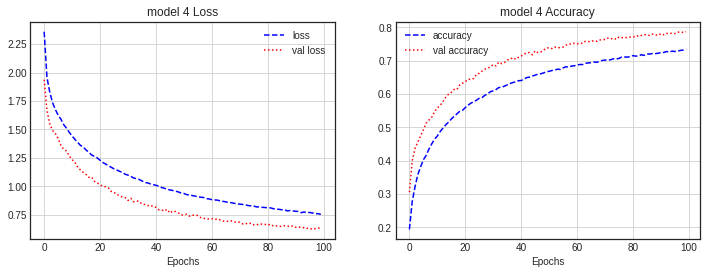

In [29]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], 'b--', label='loss')
plt.plot(history4.history['val_loss'], 'r:', label='val loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 4 Loss')

plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], 'b--', label='accuracy')
plt.plot(history4.history['val_accuracy'], 'r:', label='val accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 4 Accuracy')
plt.savefig('/content/drive/MyDrive/cifar10wCNN/model4')
plt.show()

# Model4 feedback:

평균 epoch = 100 일때 validation_accuracy = 0.78, validation_loss = 0.66 기록, <br>
epoch = 100 일때 val_acc = 0.7855, val_loss = 0.62 로 최상의 성능 보임. 
<br>
문제? : 보통 validation_accuracy 가 train_accuracy 보다 낮은데, 그 반대의 트렌드가 나타남 <br>
첫번째 assumption: data split 시 validation 데이터가 상대적으로 쉬운 문제를 풀게 되었을 가능성이 있음.

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


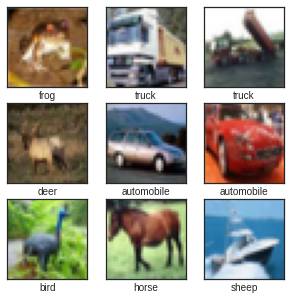

In [30]:
# Data load + preprocessing
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

print(x_train_full.shape, y_train_full.shape)
print(x_test.shape, y_test.shape) 

np.random.seed(1000) #777 에서 1000으로 변경 => 데이터셋 분류 다시하기 위함

# Data check
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog','frog','horse','sheep','truck']

sample_size = 9
random_idx = np.random.randint(60000, size=sample_size)

plt.figure(figsize = (5,5))
for i, idx in enumerate(random_idx):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train_full[i])
  plt.xlabel(class_names[int(y_train_full[i])])

plt.show()

In [31]:
# 모델 제작 위한 전처리 작업
x_mean = np.mean(x_train_full, axis=(0, 1, 2))
x_std = np.std(x_train_full, axis=(0, 1, 2))

x_train_full = (x_train_full - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3)

#Augmentation
gen = ImageDataGenerator(rotation_range=20,
                         shear_range=0.2,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         horizontal_flip=True)

augment_ratio = 1.5 # 전체 데이터의 150%
augment_size = int(augment_ratio * x_train.shape[0])

randidx = np.random.randint(x_train.shape[0], size=augment_size)

x_augmented = x_train[randidx].copy() 
y_augmented = y_train[randidx].copy()

x_augmented, y_augmented = gen.flow(x_augmented, y_augmented, #gen.flow() :  보강할 이미지 데이터 생성 매서드
                                    batch_size=augment_size,
                                    shuffle=False).next()

x_train = np.concatenate( (x_train, x_augmented) )
y_train = np.concatenate( (y_train, y_augmented) )

s = np.arange(x_train.shape[0])
np.random.shuffle(s)

x_train = x_train[s]
y_train = y_train[s]

In [35]:
# Compose model and compile (Dropout + Batch Normalisation)
def model_build5():
  model5 = Sequential()

  input = Input(shape=(32, 32, 3))

  output = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)

  output = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)


  output = Flatten()(output)
  output = Dense(256, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model5 = Model(inputs=[input], outputs=output)

  model5.compile(optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model5

In [36]:
model5 = model_build5()
model5.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0   

In [37]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1) 

history5 = model5.fit(x_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping]) 
model5.save('/content/drive/MyDrive/cifar10wCNN/model5')

Epoch 1/100
342/342 [==============================] - 6s 17ms/step - loss: 2.3770 - accuracy: 0.1854 - val_loss: 1.9994 - val_accuracy: 0.3032
Epoch 2/100
342/342 [==============================] - 5s 15ms/step - loss: 1.9693 - accuracy: 0.2677 - val_loss: 1.6720 - val_accuracy: 0.3934
Epoch 3/100
342/342 [==============================] - 5s 15ms/step - loss: 1.8401 - accuracy: 0.3146 - val_loss: 1.5595 - val_accuracy: 0.4254
Epoch 4/100
342/342 [==============================] - 5s 15ms/step - loss: 1.7533 - accuracy: 0.3474 - val_loss: 1.5311 - val_accuracy: 0.4433
Epoch 5/100
342/342 [==============================] - 5s 15ms/step - loss: 1.6911 - accuracy: 0.3744 - val_loss: 1.4929 - val_accuracy: 0.4601
Epoch 6/100
342/342 [==============================] - 5s 15ms/step - loss: 1.6477 - accuracy: 0.3933 - val_loss: 1.4595 - val_accuracy: 0.4809
Epoch 7/100
342/342 [==============================] - 5s 15ms/step - loss: 1.6069 - accuracy: 0.4079 - val_loss: 1.4652 - val_accuracy:

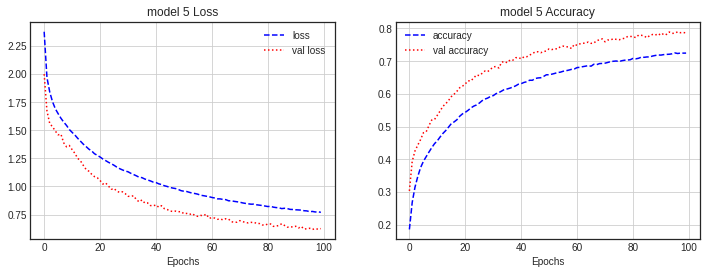

In [38]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], 'b--', label='loss')
plt.plot(history5.history['val_loss'], 'r:', label='val loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 5 Loss')

plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'], 'b--', label='accuracy')
plt.plot(history5.history['val_accuracy'], 'r:', label='val accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.title('model 5 Accuracy')
plt.savefig('/content/drive/MyDrive/cifar10wCNN/model5')
plt.show()

# Model5 Feedback
1. model 4 와 비교하여 Loss 와 Accuracy 모두 train, validation 의 갭이 줄어들지 않은 것 확인. 전반적 트렌드 model 4 와 매우 유사.
2. 이는 image augmentation 을 trainset 에만 적용했기 때문일 것으로 결론 낼 수 있음. => model 5 가 trainset 문제의 정답을 맞추는 데 더 어려움을 겪었고, 결과적으로 augmentation 이 적용되지 않은 validationset 의 정답을 맞추는 것이 보다 수월했음을 의미. 

#References

* Basic example of cifar10 and CNN from Kaggle: https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer 
* Early stopping: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
* Batch Normalisation: https://sonsnotation.blogspot.com/2020/11/8-normalization.html
* Dropout1: https://jjeongil.tistory.com/578
* Dropout2: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=laonple&logNo=220542170499
* Paper for Dropout: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
* Image Augmentation: http://machinelearningkorea.com/2019/05/19/image-augmentation-%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%98%EC%97%AC-%ED%9B%88%EB%A0%A8%EC%9A%A9-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%8A%98%EB%A6%AC%EA%B8%B0-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%B9%98%ED%8A%B8/
* Greater validation accuracy than train accuracy: https://stackoverflow.com/questions/48845354/why-is-validation-accuracy-higher-than-training-accuracy-when-applying-data-augm



